In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.models import GeoJSONDataSource, LinearColorMapper, HoverTool
from bokeh.models import Panel, Tabs
from bokeh.plotting import figure
from bokeh.palettes import Viridis256
from bokeh.layouts import column
from shapely.geometry import Point
from shapely import wkt
import json
import matplotlib.pyplot as plt
from pathlib import Path

output_notebook()

Loading BokehJS ...

In [2]:
def read_block_summaries():
    block_summ_path = Path.cwd() / 'TZA_block_summaries'
    files = []
    for file in block_summ_path.iterdir():
        files.append(gpd.read_file(file))
    block_summaries = gpd.GeoDataFrame(pd.concat(files), geometry='geometry', crs='EPSG:4326')
    return block_summaries

def read_complexities(gadm_ids):
    complexity_path = Path.cwd() / 'TZA_complexity'
    files = []
    for file in complexity_path.iterdir():
        gadm_id = file.name.strip('complexity_')
        gadm_id = gadm_id.strip('.csv')
        if gadm_id in gadm_ids and file.name.endswith('.csv'):
            files.append(pd.read_csv(file))
    complexities = pd.concat(files)
    complexities.geometry = complexities['geometry'].apply(wkt.loads)
    complexities = gpd.GeoDataFrame(complexities, geometry='geometry', crs='EPSG:4326')
    return complexities
    

In [3]:
block_summaries = read_block_summaries()
block_summaries.head()

,building,highway,name,natural,osm_id,osm_way_id,other_tags,waterway,gadm_code,bldg_id,bldg_pop,block_id,block_area,block_bldg_count,block_bldg_area,block_bldg_area_density,block_bldg_count_density,block_pop,block_pop_density,geometry
0,yes,None,None,None,6776370,None,"""type""=>""multipolygon""",None,TZA.2.3.9_1,0.0,2.721233,TZA.2.3.9_1_37,0.065090,308.0,0.022498,0.345647,4731.932617,976.333631,14999.821277,"MULTIPOLYGON (((39.31637 -6.82770, 39.31629 -6..."
1,yes,None,None,None,166790691,None,None,None,TZA.2.3.9_1,1.0,68.324020,TZA.2.3.9_1_55,0.009897,35.0,0.002809,0.283868,3536.491530,537.897407,54350.560690,"POLYGON ((39.30162 -6.82184, 39.30185 -6.82178..."
2,yes,None,None,None,180280322,None,None,None,TZA.2.3.9_1,2.0,5.679315,TZA.2.3.9_1_89,0.048449,23.0,0.006289,0.129810,474.723886,133.954674,2764.847107,"POLYGON ((39.30388 -6.82746, 39.30388 -6.82739..."
3,yes,None,None,None,180280921,None,None,None,TZA.2.3.9_1,3.0,5.440839,TZA.2.3.9_1_99,0.035703,12.0,0.003066,0.085887,336.104994,69.218064,1938.711404,"POLYGON ((39.30570 -6.83295, 39.30570 -6.83288..."
4,yes,None,None,None,374951822,None,None,None,TZA.2.3.9_1,4.0,9.875335,TZA.2.3.9_1_25,0.076583,26.0,0.002269,0.029631,339.500814,100.356723,1310.430349,"POLYGON ((39.32285 -6.82139, 39.32289 -6.82135..."


In [4]:
complexity = read_complexities(block_summaries['gadm_code'].tolist())

In [5]:
block_summary = block_summaries.drop('geometry', 1)
df = gpd.GeoDataFrame(complexity.merge(block_summary, on='block_id', how='left'))

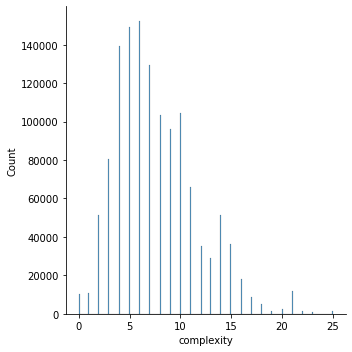

In [6]:
sns.displot(data=df, x='complexity', kind='hist');

In [7]:
print(f'There are {len(df[df["complexity"] > 15])} blocks with k complexity greater than 15')

There are 52056 blocks with k complexity greater than 15


In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 20))
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max(df['complexity'])))
ax.axis('off')
sm.set_array([]) 
fig.colorbar(sm)
df.plot(column='complexity')

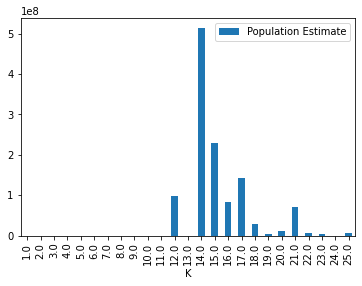

In [8]:
k_pop_estimates = []
k_pop_estimates = [sum(df[df['complexity'] == k+1]['block_pop']) for k in range(min(df['complexity']), max(df['complexity']), 1)]
k_pop_estimates = pd.DataFrame(data=[[k+1 for k in range(len(k_pop_estimates))], k_pop_estimates]).T
k_pop_estimates.columns = ['K', 'Population Estimate']
k_pop_estimates.head()
k_pop_estimates.plot.bar(x='K', y='Population Estimate');

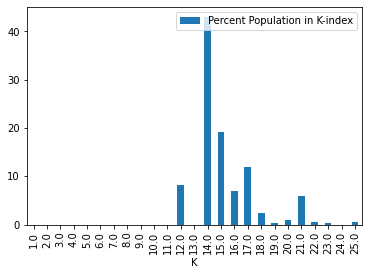

In [9]:
total_pop = k_pop_estimates['Population Estimate'].sum()
k_pop_estimates['Percent Population in K-index'] = [(pop_est/total_pop)*100 for pop_est in k_pop_estimates['Population Estimate']]
k_pop_estimates.plot.bar(x='K', y='Percent Population in K-index');

In [10]:
def summarize_by_k(df, stat, verbose=False):
    for k in range(min(df['complexity']), max(df['complexity']), 1):
        k_df = df[df['complexity']==k]
        if verbose:
            print(f'Min {stat} at k = {k} is: {k_df[stat].min()}')
            print(f'Median {stat} at k = {k} is: {k_df[stat].median()}')
            print(f'Mean {stat} at k = {k} is: {k_df[stat].mean()}')
            print(f'Max {stat} at k = {k} is {k_df[stat].max()}')
            print('\n')
    sns.barplot(x="complexity", y=stat, data=df)

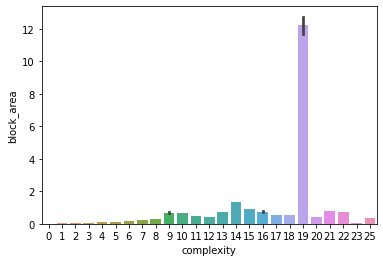

In [11]:
summarize_by_k(df, 'block_area')

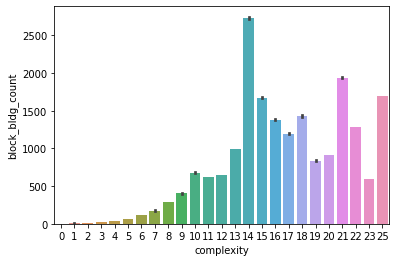

In [12]:
summarize_by_k(df, 'block_bldg_count')

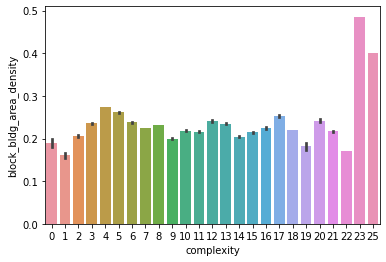

In [13]:
summarize_by_k(df, 'block_bldg_area_density')